## Goal
try to use efficientDet to analysis the difference between pure-data and data-augmentation.

[EfficientDet github](https://github.com/google/automl/tree/master/efficientdet)  
[roboflow training](https://colab.research.google.com/drive/1ZmbeTro4SqT7h_TfW63MLdqbrCUk_1br?ref=blog.roboflow.com#scrollTo=NLzZXkkhrvx4)  
[Dataset](https://github.com/TW0521/Obstacle-Dataset)  
[LAKE-RED](https://github.com/PanchengZhao/LAKE-RED)  

### set up environment

In [1]:
#our fork of the Tessellate-Imaging image detection library
#!rm -rf Monk_Object_Detection
! git clone https://github.com/roboflow-ai/Monk_Object_Detection.git

fatal: destination path 'Monk_Object_Detection' already exists and is not an empty directory.


In [2]:
# For colab use the command below
# Set up library requirments
! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_colab.txt | xargs -n 1 -L 1 pip install

xargs: warning: options --max-args and -L are mutually exclusive, ignoring previous --max-args value
  Cloning https://github.com/abhi-kumar/cocoapi.git to /tmp/pip-install-dt830tux/pycocotools_2fe7c5c8ac8a4b83b7f52adfb529483a
  Running command git clone --filter=blob:none --quiet https://github.com/abhi-kumar/cocoapi.git /tmp/pip-install-dt830tux/pycocotools_2fe7c5c8ac8a4b83b7f52adfb529483a
  Resolved https://github.com/abhi-kumar/cocoapi.git to commit 1d6d019f8938f47a9b5af28685011898b25ff93a
  Preparing metadata (setup.py) ... done


Avoid [TypeError: Descriptors cannot not be created directly](https://stackoverflow.com/questions/72441758/typeerror-descriptors-cannot-not-be-created-directly), modify protobuf

In [12]:
#fixed version of tqdm output for Colab
!pip install tqdm
!pip install protobuf==3.20.*
# !pip install --force https://github.com/chengs/tqdm/archive/colab.zip
#IGNORE restart runtime warning, it is indeed installed
#missing a few extra packages that we will need later!
!pip install efficientnet_pytorch==0.7.0
!pip install tensorboardX==2.1
# !pip install onnx onnxruntime

## Show data distribution

In [ ]:
label = ["stop_sign","person","bicycle","bus","truck","car","motorbike","reflective_cone","ashcan","warning_column","spherical_roadblock","pole","dog","tricycle","fire_hydrant"]
id2label = {k: v for k, v in enumerate(label)}
print(id2label)

{0: 'stop_sign', 1: 'person', 2: 'bicycle', 3: 'bus', 4: 'truck', 5: 'car', 6: 'motorbike', 7: 'reflective_cone', 8: 'ashcan', 9: 'warning_column', 10: 'spherical_roadblock', 11: 'pole', 12: 'dog', 13: 'tricycle', 14: 'fire_hydrant'}


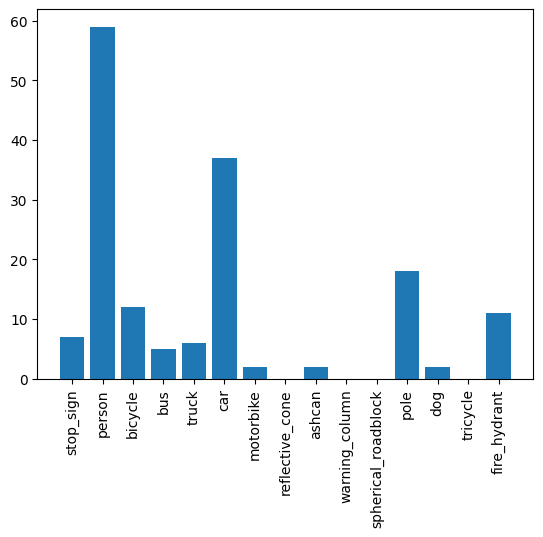

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
path = '/content/original/labels'

count = {i:0 for i in range(len(id2label))}
files = os.listdir(path)

# 統計出現次數
for file in files:
  txt = os.path.join(path, file)
  with open(txt, "r") as f:
    lines = f.readlines()
    for line in lines:
      count[int(line.split()[0])] += 1

# draw bar distribution
plt.bar(range(len(count)), count.values(), align='center')
plt.xticks(range(len(count)), [id2label[i] for i in count.keys()], rotation=90)
plt.show()

## Preprocessing with roboflow
- Auto-orientation：移除 EXIF 中的方向資訊，確保影像正確顯示。
- Resize 處理：所有圖片統一拉伸為 640×640 像素，以符合模型輸入需求。

## do some data augmentation with roboflow
- 水平翻轉：以 50% 機率進行左右翻轉。
- 角度隨機旋轉：隨機旋轉至原角度、順時針 90° 或逆時針 90°。
- 小角度旋轉：隨機在 -15° 到 +15° 之間旋轉。
- 亮度變化：進行 ±15% 的亮度調整。
- 高斯模糊：施加 0 至 2.5 px 的模糊處理，以模擬不同成像清晰度。
- 噪音: 對圖片添加 0.2% 雜訊

依此設定放大資料集，從原本 35 張放大成 105 張。

In [ ]:
#fresh curl courtesy of roboflow.ai, outputing our dataset in Coco Json format

!curl -L "https://app.roboflow.com/ds/FE0pxvwzZA?key=tWaZo1L9kr" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   901  100   901    0     0   3217      0 --:--:-- --:--:-- --:--:--  3217
100 7377k  100 7377k    0     0  9982k      0 --:--:-- --:--:-- --:--:-- 9982k
Archive:  roboflow.zip
  inflating: README.dataset.txt      
  inflating: README.roboflow.txt     
   creating: train/
 extracting: train/000000000064_jpg.rf.0b753a5624b59772bfa748ce3f16b925.jpg  
 extracting: train/000000000064_jpg.rf.3e869450db4fe1088230a5f8bbd5918d.jpg  
 extracting: train/000000000064_jpg.rf.f61bb6ef7c4eacdc34c8b084f8d76d8c.jpg  
 extracting: train/000000000074_jpg.rf.7eec127a46a5321b3f809c02b4701901.jpg  
 extracting: train/000000000074_jpg.rf.e7c4f33f9c71129d9bcf4be1e9c518cf.jpg  
 extracting: train/000000000074_jpg.rf.e947b1ff6ab89526283661f248170617.jpg  
 extracting: train/000000002753_jpg.rf.6d664286769e1740c888560d597a0127.jpg  
 extracting: train/

In [ ]:
%ls

Monk_Object_Detection/  README.roboflow.txt  train/
README.dataset.txt      sample_data/


In [ ]:
#in the next three cells, we move the data into a structure that the image detection library will be expecting
#but no file data manipulation is necessary
#images can also be segmented into class folders, but we combine all classes here
!mkdir CV
!mkdir CV/annotations
!mkdir CV/Annotations
!mkdir CV/Images

In [ ]:
%cp train/_annotations.coco.json CV/annotations/instances_Images.json

In [ ]:
%cp train/*.jpg CV/Images/

## 前置實驗
看看預訓練模型用真實資料簡單訓練後，對判斷生成資料的效果如何

In [3]:
import os
import sys
sys.path.append("/content/Monk_Object_Detection/4_efficientdet/lib/");

In [4]:
from train_detector import Detector

/usr/local/lib/python3.11/dist-packages/tqdm/autonotebook/__init__.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  warn("Using `tqdm.autonotebook.tqdm` in notebook mode."


In [5]:
gtf = Detector();

In [6]:
#directs the model towards file structure
root_dir = "./";
coco_dir = "CV";
img_dir = "./";
set_dir = "Images";

In [7]:
#smells like some free compute from Colab, nice
# gtf.system_dict["local"]["num_gpus"] = 1
# gtf.Train_Dataset(root_dir, coco_dir, img_dir, set_dir, batch_size=8, image_size=512, use_gpu=False)
gtf.Train_Dataset(root_dir, coco_dir, img_dir, set_dir, batch_size=1, image_size=256, use_gpu=True)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
gtf.Model();

Loaded pretrained weights for efficientnet-b0


In [9]:
gtf.Set_Hyperparams(lr=0.0001, val_interval=1, es_min_delta=0.0, es_patience=0)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [10]:
%%time
gtf.Train(num_epochs=30, model_output_dir="trained/");

/content/Monk_Object_Detection/4_efficientdet/lib/src/model.py:251: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  if len(inputs) == 2:
/content/Monk_Object_Detection/4_efficientdet/lib/src/utils.py:84: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  image_shape = np.array(image_shape)
/content/Monk_Object_Detection/4_efficientdet/lib/src/utils.py:96: TracerWarning: torch.from_numpy results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any 

faild onnx export



faild onnx export



faild onnx export



faild onnx export



faild onnx export



faild onnx export



faild onnx export



faild onnx export



faild onnx export



faild onnx export



faild onnx export



faild onnx export



faild onnx export



faild onnx export



faild onnx export



faild onnx export



faild onnx export



faild onnx export



faild onnx export



faild onnx export



faild onnx export



faild onnx export



faild onnx export



faild onnx export



faild onnx export



faild onnx export


CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 10.12 MiB is free. Process 430246 has 14.73 GiB memory in use. Of the allocated memory 14.34 GiB is allocated by PyTorch, and 273.90 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 10.12 MiB is free. Process 430246 has 14.73 GiB memory in use. Of the allocated memory 14.33 GiB is allocated by PyTorch, and 282.90 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/not

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


faild onnx export


CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 10.12 MiB is free. Process 430246 has 14.73 GiB memory in use. Of the allocated memory 14.34 GiB is allocated by PyTorch, and 273.90 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 10.12 MiB is free. Process 430246 has 14.73 GiB memory in use. Of the allocated memory 14.33 GiB is allocated by PyTorch, and 282.90 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/not

CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 10.12 MiB is free. Process 430246 has 14.73 GiB memory in use. Of the allocated memory 14.34 GiB is allocated by PyTorch, and 273.90 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 10.12 MiB is free. Process 430246 has 14.73 GiB memory in use. Of the allocated memory 14.33 GiB is allocated by PyTorch, and 282.90 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/not

CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 10.12 MiB is free. Process 430246 has 14.73 GiB memory in use. Of the allocated memory 14.34 GiB is allocated by PyTorch, and 273.90 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 10.12 MiB is free. Process 430246 has 14.73 GiB memory in use. Of the allocated memory 14.33 GiB is allocated by PyTorch, and 282.90 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/not

In [11]:
from infer_detector import Infer

In [12]:
gtf_inf = Infer();

Avoid [WeightsUnpickler error](https://github.com/ultralytics/ultralytics/issues/19824)，specific pytorch version less than 2.6

In [ ]:
!pip uninstall torch torchvision
!pip install "torchvision<0.20"
!pip install "torch<2.6.0"

In [13]:
#our trained model weights are in here in onxx format
gtf_inf.Model(model_dir="/content/trained/")

/content/Monk_Object_Detection/4_efficientdet/lib/infer_detector.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.system_dict["local"]["model"] = torch.load(model_d

In [14]:
#extract class list from our annotations
import json
with open('train/_annotations.coco.json') as json_file:
    data = json.load(json_file)
class_list = []
for category in data['categories']:
  class_list.append(category['name'])

# output
class_list

['items',
 'bicycle',
 'bus',
 'car',
 'dog',
 'fire_hydrant',
 'motorbike',
 'person',
 'pole',
 'spherical_roadblock',
 'stop_sign']

Predicting 000000016805_jpg.rf.ff88c867a312549d070283f018b6d617.jpg...
Done. (0.033s)
NO Object Detected
❌ No object detected in 000000016805_jpg.rf.ff88c867a312549d070283f018b6d617.jpg
Predicting 000000002753_jpg.rf.849cb6a65d4a3d371144e6133811b7fc.jpg...
Done. (0.032s)
NO Object Detected
❌ No object detected in 000000002753_jpg.rf.849cb6a65d4a3d371144e6133811b7fc.jpg
Predicting 000000385972_jpg.rf.89b2f53843cf999ffbc5bccdf8fbe3d5.jpg...
Done. (0.047s)
NO Object Detected
❌ No object detected in 000000385972_jpg.rf.89b2f53843cf999ffbc5bccdf8fbe3d5.jpg
Predicting 000000042366_jpg.rf.e1ec206a838c9a53a478aa198e18d728.jpg...
Done. (0.032s)
NO Object Detected
❌ No object detected in 000000042366_jpg.rf.e1ec206a838c9a53a478aa198e18d728.jpg


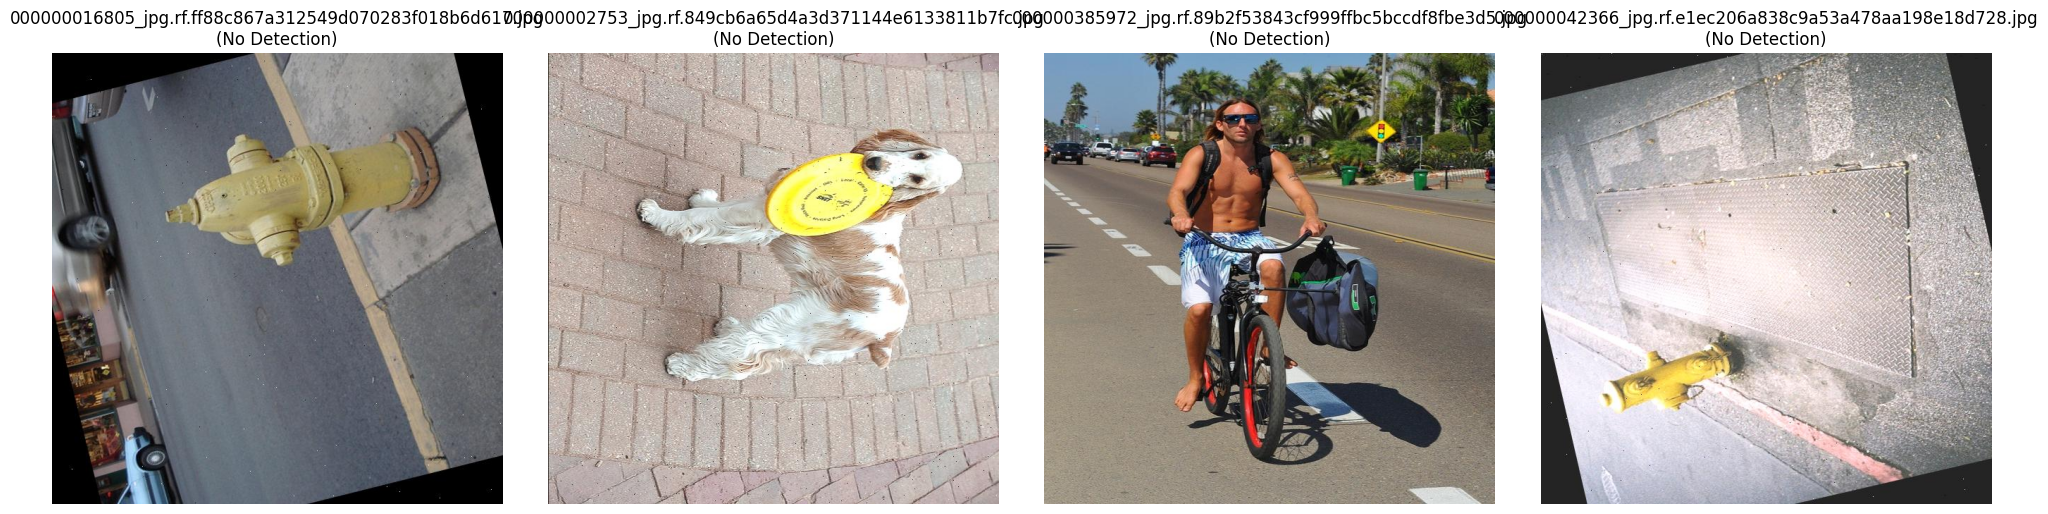

In [26]:
import os
import random
import matplotlib.pyplot as plt
import cv2

# 要推論幾張圖片
batch_size = 4

# 隨機選擇 batch_size 張圖片
test_images = [f for f in os.listdir('/content/train') if f.endswith('.jpg')]
batch_paths = random.sample(test_images, batch_size)

# 畫圖用
fig, axs = plt.subplots(1, batch_size, figsize=(20, 5))

for i, filename in enumerate(batch_paths):
    img_path = os.path.join("/content/train", filename)
    print(f"Predicting {filename}...")

    # 預測
    result = gtf_inf.Predict(img_path, class_list, vis_threshold=0.4)

    # 預測結果為 None（沒抓到物件），則跳過
    if result is None:
        print(f"❌ No object detected in {filename}")
        axs[i].imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
        axs[i].axis('off')
        axs[i].set_title(f"{filename}\n(No Detection)")
        continue

    duration, scores, labels, boxes = result

    # 讀圖用 OpenCV
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 畫出每個 bbox
    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        label_text = f"{label} ({score:.2f})"
        cv2.putText(img, label_text, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (255, 0, 0), 1, cv2.LINE_AA)

    # 顯示在 subplot 上
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(filename)

plt.tight_layout()
plt.show()


因為解決不了 `Cuda out of memory` 問題，所以 train 不好..。